# VNA Data Acquisition Notebook

Welcome to the VNA FMR data acquisition notebook! This notebook is designed to help you take measurements of the VNA FMR experiment using the Rohde & Schwarz VNA ZVA 40 and KEPCO Bioperational Power Supply (BOP). You can extract the S-parameters, and measure and visualize the Power Absorbed spectra during the FMR experiment. The entire setup has been arranged at the Spin Physics Lab @ LUMS (project of PhysLab).

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import savgol_filter

plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings('ignore')
import pyvisa

from func import filters as fil
from func import Crop, Plot, Calc, Load, Fitting, FWHM

In [3]:
# Initialize VISA resource manager
rm = pyvisa.ResourceManager()
print(rm.list_resources())

('GPIB0::6::INSTR', 'GPIB0::8::INSTR', 'GPIB0::20::INSTR', 'ASRL3::INSTR')


# 1 Port

### Initializing 1 Port Experiment

In [4]:
from VNAxKEPCO_1P import Experiment1P

E1 = Experiment1P()

You're now using the VNA 1-Port FMR Experiment!
Here are some default experiment parameters.

PS Output Current (A) :	 0.00255
PS Output Voltage (V) :	 23.7857
PS Output Mode (Current/Voltage) :	 Constant Current
Log File :	 c:\Users\plyslab\Desktop\VNA Automation\Experiment_Logs\FMR_log_2023-12-22_13-41-40.log


### Frequency Sweep

In [6]:
ref_field = 400
start_freq = 0.5
stop_freq = 6
step = 20e6 # 20 MHz
start_freq, stop_freq = start_freq * 1e9, stop_freq * 1e9
num_points = (stop_freq - start_freq)/step + 1
fields = np.linspace(0, 400, 201) 

### Change this ###
sample = 'NiFe'
file_name = f'1_Port_{sample}_{start_freq/1e9}-{stop_freq/1e9}_GHz_@_{fields.min()}-{fields.max()}_Oe'
dir = fr'C:\Users\plyslab\Desktop\VNA Automation\Data\Scratch\{file_name}'

E1.MeasureRef(ref_field, start_freq, stop_freq, num_points, dir)
E1.Measure(start_freq, stop_freq, num_points, fields, dir)

### Data Loading

In [7]:
dir = r'c:\Users\plyslab\Desktop\VNA Automation\Data\Spin_pumping\1_Port_MgO5NiFe20Mgo15_0o_0.3-15.0_GHz_@_-1000.0-1000.0_Oe'

Info, freq, field, RefS11, S11 = Load.NPZ_1P(dir)

### S11 Plots

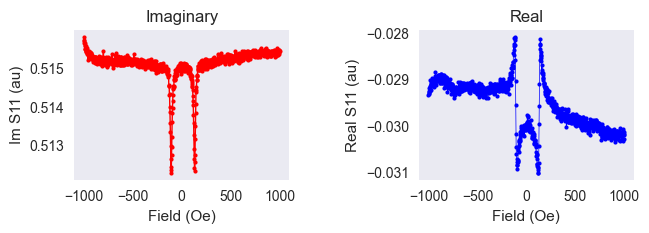

In [8]:
specified_freq = 3

Plot.S_parameter(freq, field, specified_freq, S11)

#### SET FREQUENCY AND FIELD BOUNDS

In [15]:
lower_freq = 0.5
upper_freq = 6
lower_field = -500
upper_field = 500

In [16]:
freq_used = Crop.cut_freq(freq, lower_freq, upper_freq)[0]
lower_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[1]
upper_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[2]

field_used = Crop.cut_field(field, lower_field, upper_field)[0]
lower_field = Crop.cut_freq(field, lower_field, upper_field)[1]
upper_field = Crop.cut_freq(field, lower_field, upper_field)[2]

### Visualizng Filtered Data

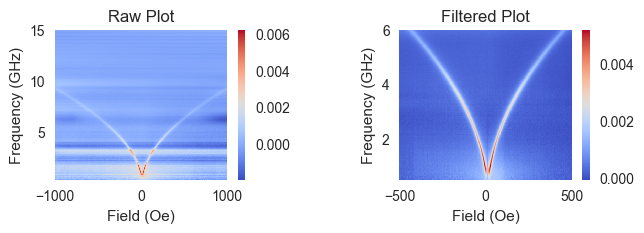

In [17]:
abspow = Calc.AbsPower1P(S11, RefS11) # Power Absorbed
    
filteredData = fil.Filter_Spline(abspow, a=0.1)
filteredData = fil.FilterBG_Median(filteredData)
filteredData = fil.FilterBG_MedianH(filteredData)

cutData = filteredData[lower_freq:upper_freq, lower_field:upper_field]

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.pcolormesh(field, freq, abspow, cmap='coolwarm')
plt.colorbar()
plt.ylabel('Frequency (GHz)')
plt.xlabel('Field (Oe)')
plt.title('Raw Plot')

plt.subplot(1,2,2)
plt.pcolormesh(field_used, freq_used, cutData, cmap='coolwarm')  #gist_heat #inferno #plasma #jet #gist_grey #coolwarm 
plt.colorbar()
plt.xlabel('Field (Oe)')
plt.ylabel('Frequency (GHz)')
plt.title('Filtered Plot')

plt.subplots_adjust(left=0.2, right=0.9, bottom=1, top=1.5, wspace=0.6, hspace=1)

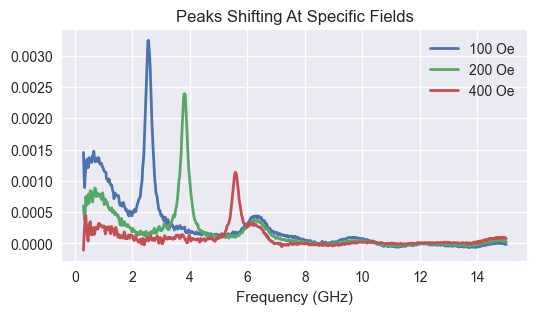

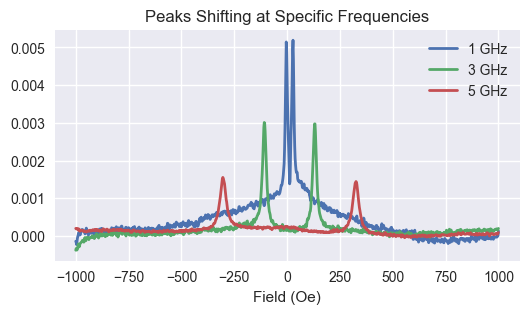

In [20]:
### Field
plt.figure(figsize=(6,3))
Plot.plotH(filteredData, H=100, f=freq, field=field)
Plot.plotH(filteredData, H=200, f=freq, field=field)
Plot.plotH(filteredData, H=400, f=freq, field=field)
plt.legend()
plt.title('Peaks Shifting At Specific Fields')
plt.show()

### Frequency
plt.figure(figsize=(6,3))
Plot.plotF(filteredData, F=1, h=field, freq=freq)
Plot.plotF(filteredData, F=3, h=field, freq=freq)
Plot.plotF(filteredData, F=5, h=field, freq=freq)
plt.legend()
plt.title('Peaks Shifting at Specific Frequencies')
plt.show()

### Single dP/dH Plot

Estimated total time for data acquisition: 1.9 min


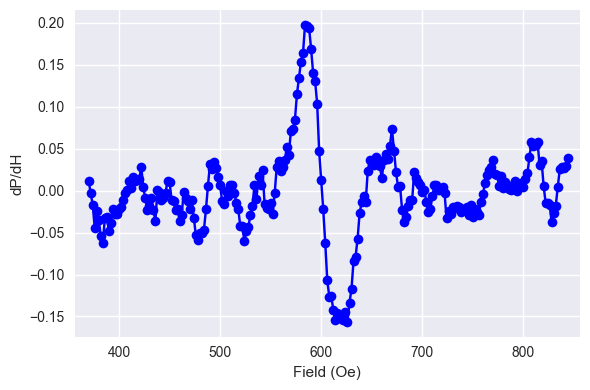

In [ ]:
import pandas as pd

frequency = 5
field = field_used

d = Plot.Fdata(cutData, F=frequency, h=field_used, freq=freq_used)
max_field = field[np.argmax(d)]
field_below, field_above = 150, 150
lower = max_field - field_below
if lower < 0:
    lower = 0

upper = max_field + field_above
fields = np.linspace(lower, upper, round((field_below + field_above) / 2) + 1)
frequency *= 1e9
data = E1.Measure_dPdH(frequency, fields, file_name=None, read_reps=3, delta_H=15)
df = pd.DataFrame({'Fields': fields, 'Data': data})

# Convert DataFrame to CSV (Set Directory)
sample = 'Ti5NiFeIrMnTi_90o'
file_name = f'1_Port_dPdH_{sample}_{frequency/1e9}_GHz_@_{fields.min()}-{fields.max()}_Oe'
dir = fr'C:\Users\plyslab\Desktop\VNA Automation\Data\Spin_pumping\dPdH\{file_name}.csv'
df.to_csv(dir, index=False)

### Shift dP/dH (only considering positive fields)

In [1]:
import pandas as pd

start = 1
stop = 5
interval = 0.5
frequencies = np.arange(start, stop+interval, interval)
field = field_used

for fr in frequencies:
    d = Plot.Fdata(cutData, F=fr, freq=freq_used)
    max_field = field[np.argmax(d)]
    field_below, field_above = 150, 150
    lower = max_field - field_below
    if lower < 0:
        lower = 0

    upper = max_field + field_above
    fields = np.linspace(lower, upper, round((field_below + field_above) / 2) + 1)
    fr *= 1e9
    data = E1.Measure_dPdH(fr, fields, file_name=None, read_reps=3, delta_H=5, returnData=True)
    df = pd.DataFrame({'Fields': fields, 'Data': data})

    # Convert DataFrame to CSV (Set Directory)
    sample = 'Ti5NiFeIrMnTi'
    file_name = f'1 Port dPdH {sample} {fr/1e9} GHz @ {fields.min()}-{fields.max()} Oe'
    dir = fr'C:\Users\plyslab\Desktop\VNA Automation\Shift dPdH\Ti5NiFeIrMnTi\{file_name}.csv'
    df.to_csv(dir, index=False)

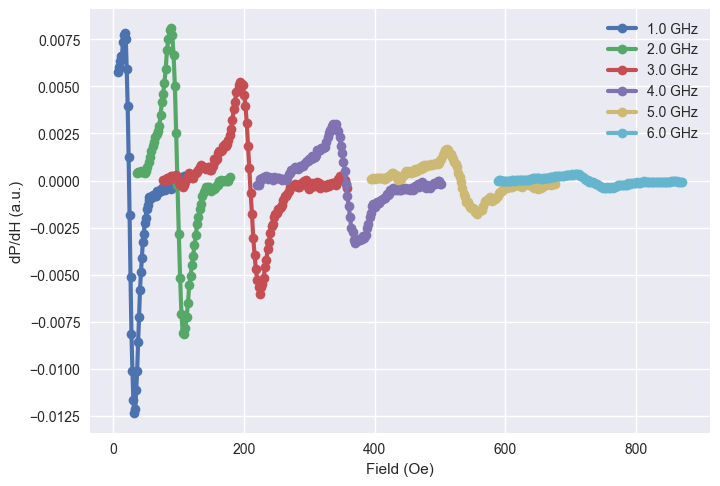

In [22]:
# Specify the directory path
directory_path = r'C:\Users\plyslab\Desktop\VNA Automation\Shift dPdH\TiNiFeTi'

Plot.shift_dPdH(directory_path)

# 2 Port 

### Initializing Experiment

In [ ]:
from VNAxKEPCO_2P import Experiment2P

E2 = Experiment2P()

Welcome to the VNA 2-Port FMR Experiment!
Here are some default experiment parameters.

PS Output Current (A) :	 6.27584
PS Output Voltage (V) :	 -46.9193
PS Output Mode (Current/Voltage) :	 Constant Current
Log File :	 c:\Users\plyslab\Desktop\VNA Automation\Experiment_Logs\FMR_log_2023-12-21_13-49-17.log


### Frequency Sweep

In [3]:
import numpy as np 

ref_field = 500
start_freq = 0.1
stop_freq = 5
step = 20e6 # 20MHz
start_freq, stop_freq = start_freq * 1e9, stop_freq * 1e9
num_points = (stop_freq - start_freq)/step + 1

fields = np.linspace(-350, 350, 301) 

sample = 'NiFe'
file_name = f'2Port_{sample}_{round(start_freq/1e9, 1)}-{round(stop_freq/1e9, 1)}_GHz_@_{fields.min()}-{fields.max()}_Oe'
dir = fr'C:\Users\plyslab\Desktop\VNA Automation\Data\2port\NiFe\{file_name}'

E2.MeasureRef(ref_field, start_freq, stop_freq, num_points, dir)
E2.Measure(start_freq, stop_freq, num_points, fields, dir)

### Data Loading

In [2]:
dir = r'c:\Users\plyslab\Desktop\VNA Automation\Data\2port\NiFe_test\2Port_NiFe_test_0.1-5.0_GHz_@_-250.0-250.0_Oe'

Info, freq, field, RefS11, RefS21, RefS22, RefS12, S11, S12, S21, S22 = Load.NPZ_2P(dir)

### S-Parameter Plots (S11 & S21)

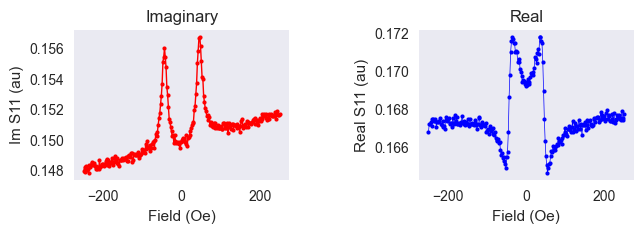

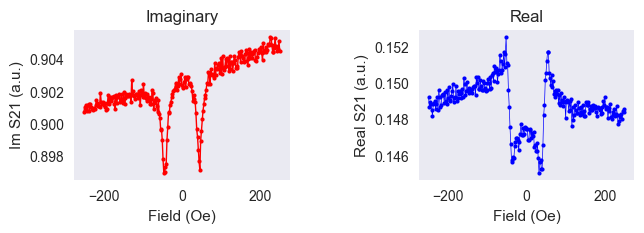

In [3]:
specified_freq = 2

Plot.S_parameter(freq, field, specified_freq, S11, S21)

### Set Frequency and Field Bounds

In [4]:
lower_freq = 0.5
upper_freq =  5
lower_field = -250
upper_field = 250

In [5]:
freq_used = Crop.cut_freq(freq, lower_freq, upper_freq)[0]
lower_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[1]
upper_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[2]

field_used = Crop.cut_field(field, lower_field, upper_field)[0]
lower_field = Crop.cut_freq(field, lower_field, upper_field)[1]
upper_field = Crop.cut_freq(field, lower_field, upper_field)[2]

### Visualize Raw & Filtered Plots

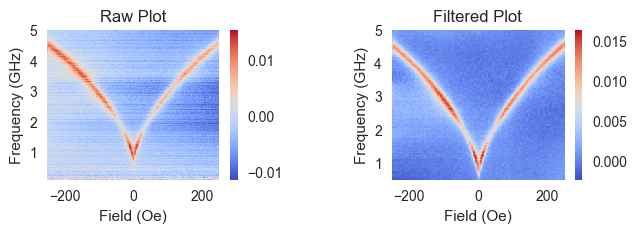

In [6]:
abspow = Calc.AbsPower2P(S11, S21, RefS11, RefS21)
    
filteredData = fil.Filter_Spline(abspow, a=0.1)
filteredData = fil.FilterBG_Median(filteredData)
filteredData = fil.FilterBG_MedianH(filteredData)

cutData = filteredData[lower_freq:upper_freq, lower_field:upper_field]

plt.figure(figsize=(8,3))
extent = [field_used.min(), field_used.max(), freq_used.min(), freq_used.max()]
cmap = 'coolwarm' #gist_gray

plt.subplot(1,2,1)
plt.pcolormesh(field, freq, abspow, cmap=cmap)
plt.colorbar()
plt.ylabel('Frequency (GHz)')
plt.xlabel('Field (Oe)')
plt.title('Raw Plot')

plt.subplot(1,2,2)
plt.imshow(cutData, interpolation='nearest',
       origin='lower',
       cmap=cmap,
       aspect='auto',
       extent=extent)
plt.colorbar()
plt.grid(False)
plt.xlabel('Field (Oe)')
plt.ylabel('Frequency (GHz)')
plt.title('Filtered Plot')

plt.subplots_adjust(left=0.2, right=0.9, bottom=1, top=1.5, wspace=0.6, hspace=1)


### Line Plots For Specific Field and Frequency

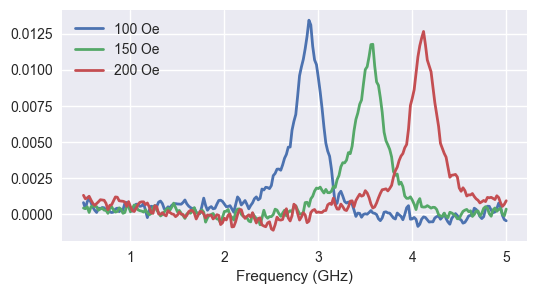

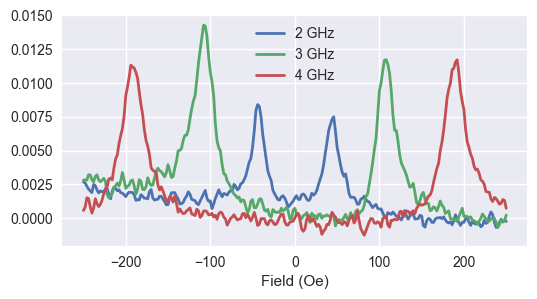

In [7]:
### Field
plt.figure(figsize=(6,3))
Plot.plotH(cutData, H=100, f=freq_used, field=field_used)
Plot.plotH(cutData, H=150, f=freq_used, field=field_used)
Plot.plotH(cutData, H=200, f=freq_used, field=field_used)
plt.legend()
plt.show()

### Frequency
plt.figure(figsize=(6,3))
Plot.plotF(cutData, F=2, h=field_used, freq=freq_used)
Plot.plotF(cutData, F=3, h=field_used, freq=freq_used)
Plot.plotF(cutData, F=4, h=field_used, freq=freq_used)
plt.legend()
plt.show()

### Single dP/dH Plot

Estimated total time for data acquisition: 1.2 min


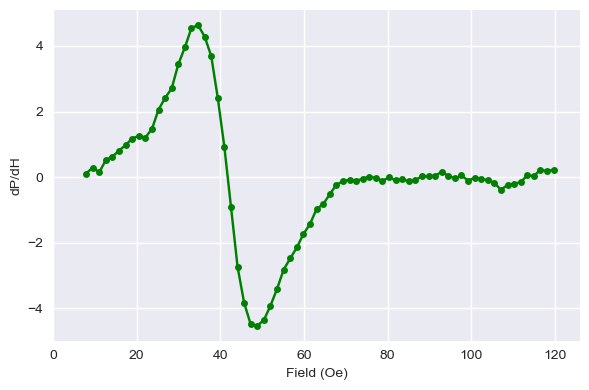

In [ ]:
import pandas as pd

frequency = 2 * 1e9
field_below = 80
field_above = 80
lower = Calc.concentrated_dpdh(cutData, frequency, field_used, freq_used*1e9, field_below, field_above)[0]
upper = Calc.concentrated_dpdh(cutData, frequency, field_used, freq_used*1e9, field_below, field_above)[1]
fields = np.linspace(lower, upper, round((field_below + field_above) / 2) + 1)

data = E2.Measure_dPdH(frequency, fields, file_name=None, read_reps=3, delta_H=5, returnData=True)
df = pd.DataFrame({'Fields': fields, 'dPdH Data': data})

# Convert DataFrame to CSV (Set Directory)
sample = 'NiFe_test'
file_name = f'2_Port_dPdH_{sample}_{frequency/1e9}_GHz_@_{fields.min()}-{fields.max()}_Oe'
dir = fr'C:\Users\plyslab\Desktop\VNA Automation\Data\2port\dPdH\{file_name}.csv'
df.to_csv(dir, index=False)

### Shift dP/dH (only considering positive fields)

In [2]:
import pandas as pd

start = 2
stop = 5
interval = 0.1
frequencies = np.arange(start, stop+interval, interval)
field = field_used

for fr in frequencies:
    d = Plot.Fdata(cutData, F=fr, freq=freq_used)
    max_field = field[np.argmax(d)]
    field_below, field_above = 100, 100
    lower = max_field - field_below
    if lower < 0:
        lower = 0

    upper = max_field + field_above
    fields = np.linspace(lower, upper, round((field_below + field_above) / 2) + 1)
    fr *= 1e9
    data = E2.Measure_dPdH(fr, fields, file_name=None, read_reps=3, delta_H=5, returnData=True)
    df = pd.DataFrame({'Fields': fields, 'dPdH Data': data})

    # Convert DataFrame to CSV (Set Directory)
    sample = 'NiFe_test'
    file_name = f'2_Port_dPdH_{sample}_{round(fr/1e9, 1)}_GHz_@_{fields.min()}-{fields.max()}_Oe'
    dir = fr'C:\Users\plyslab\Desktop\VNA Automation\Data\2port\Shift dPdH\NiFe_test\{file_name}.csv'
    df.to_csv(dir, index=False)

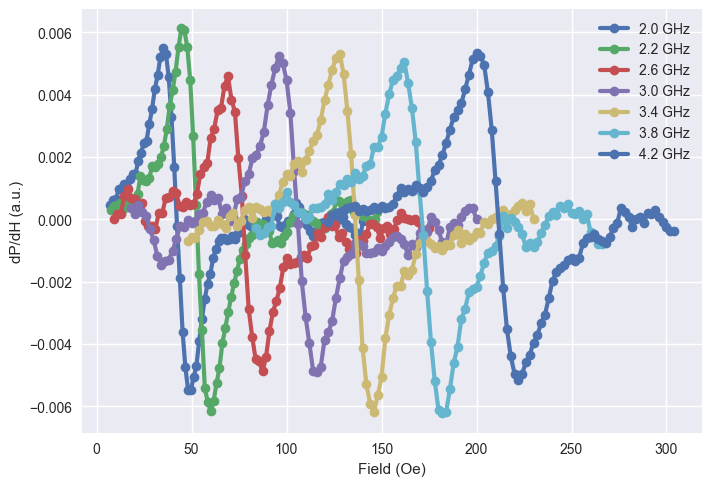

In [8]:
# Specify the directory path
directory_path = r'C:\Users\plyslab\Desktop\VNA Automation\Data\2port\Shift dPdH\NiFe_test'

Plot.shift_dPdH(directory_path)